In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import pylab as pl
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8
import matplotlib.pyplot as pl
import seaborn as sns
data = pd.read_csv('avocado.csv')

# Clean data

In [2]:
data['Date'] = pd.to_datetime(data['Date'])
data.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,47,2017-02-05,0.66,11274749.11,4377537.67,2558039.85,193764.89,4145406.70,2508731.79,1627453.06,9221.85,conventional,2017,West
1,47,2017-02-05,0.67,11213596.29,3986429.59,3550403.07,214137.93,3462625.70,3403581.49,7838.83,51205.38,conventional,2017,California
2,7,2018-02-04,0.80,10894677.77,4473811.63,4097591.67,146357.78,2176916.69,2072477.62,34196.27,70242.80,conventional,2018,California
3,7,2018-02-04,0.83,10565056.41,3121272.58,3294335.87,142553.21,4006894.75,1151399.33,2838239.39,17256.03,conventional,2018,West
4,46,2016-02-07,0.70,10361698.17,2930343.28,3950852.38,424389.60,3056112.91,2693843.02,344774.59,17495.30,conventional,2016,California


In [3]:
data.info

<bound method DataFrame.info of        Unnamed: 0       Date  AveragePrice  Total Volume        4046  \
0              47 2017-02-05          0.66   11274749.11  4377537.67   
1              47 2017-02-05          0.67   11213596.29  3986429.59   
2               7 2018-02-04          0.80   10894677.77  4473811.63   
3               7 2018-02-04          0.83   10565056.41  3121272.58   
4              46 2016-02-07          0.70   10361698.17  2930343.28   
5               7 2018-02-04          0.65   10323174.59  4772921.95   
6              46 2016-02-07          0.69    9718438.84  3353158.49   
7              47 2017-02-05          0.62    9421609.22  5160896.68   
8              47 2015-02-01          0.85    9032180.67  4794142.14   
9               0 2018-03-25          0.70    9010588.32  3999735.71   
10             33 2016-05-08          0.75    8706859.44  2987238.83   
11             34 2015-05-03          0.88    8567534.49  4340117.03   
12             34 2017-05-07    

In [4]:
data.isnull().sum()

Unnamed: 0      0
Date            0
AveragePrice    0
Total Volume    0
4046            0
4225            0
4770            0
Total Bags      0
Small Bags      0
Large Bags      0
XLarge Bags     0
type            0
year            0
region          0
dtype: int64

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


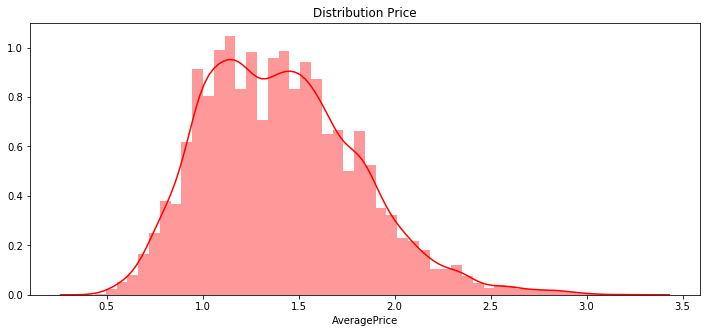

In [5]:
pl.figure(figsize=(12,5))
pl.title("Distribution Price")
ax = sns.distplot(data["AveragePrice"], color = 'r')

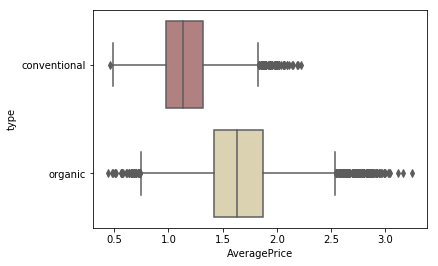

In [6]:
sns.boxplot(y="type", x="AveragePrice", data=data, palette = 'pink')


In [7]:
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()
dicts = {}

label.fit(data.type.drop_duplicates()) 
dicts['type'] = list(label.classes_)
data.type = label.transform(data.type) 

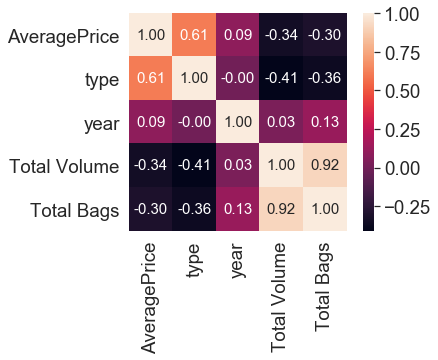

In [8]:
cols = ['AveragePrice','type','year','Total Volume','Total Bags']
cm = np.corrcoef(data[cols].values.T)
sns.set(font_scale = 1.7)
hm = sns.heatmap(cm,cbar = True, annot = True,square = True, fmt = '.2f', annot_kws = {'size':15}, yticklabels = cols, xticklabels = cols)

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split
#from sklearn import cross_validation
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
import warnings
warnings.filterwarnings('ignore')


In [10]:
# x = data[['Total Volume','type']]
x = data.drop(['AveragePrice','region','Date'], axis = 1)
y = data.AveragePrice

x_train,x_test,y_train,y_test = train_test_split(x,y,random_state = 0)

In [11]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(x_train, y_train)
mean_squared_error(y_test, reg.predict(x_test))

0.09491748921469435

In [12]:
from sklearn import linear_model`
lasso = linear_model.Lasso(alpha=0.1).fit(x_train, y_train)
lasso.predict(x_test)
mean_squared_error(y_test, lasso.predict(x_test))

0.14186520044862683

In [13]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=10.0).fit(x_train,y_train)
ridge.predict(x_test)
mean_squared_error(y_test, ridge.predict(x_test))

0.0949119692143363

In [14]:
coef_table = pd.DataFrame()
coef_table['LR'] = reg.coef_
coef_table['Lasso'] = lasso.coef_
coef_table['Ridge'] = ridge.coef_
coef_table.head()

,LR,Lasso,Ridge
0,-0.003036,-2.744284e-03,-0.003035
1,-0.000121,-1.278573e-07,-0.000120
2,0.000121,-6.409492e-08,0.000120
3,0.000121,8.382150e-08,0.000120
4,0.000120,-4.934200e-07,0.000120


In [15]:
cpdf = pd.DataFrame()
cpdf['Value'] = y_test
cpdf['Ridge'] = ridge.predict(x_test)
cpdf['Lasso'] = lasso.predict(x_test)
cpdf['LR'] = reg.predict(x_test)

In [16]:
cpdf.head()

,Value,Ridge,Lasso,LR
8933,1.74,1.680373,1.489009,1.681074
1644,1.32,1.213276,1.363053,1.212817
2330,1.42,1.249577,1.343587,1.249025
2777,1.11,1.135754,1.373590,1.135014
4173,1.09,1.125987,1.406338,1.125058


In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

#plt.plot( data['Total Volume'], data['AveragePrice'],'.')

In [18]:
#from IPython.display import Image
#Image("year_plot.png")

In [19]:
#data['Money'] = data['AveragePrice']*data['Total Volume']

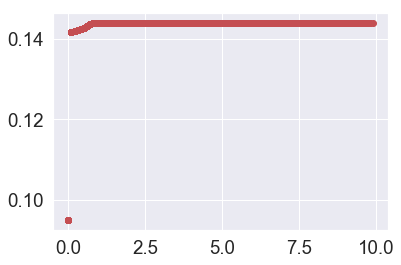

In [20]:
lasso_coef = []
index =[]
for i in range (100):
    lasso = linear_model.Lasso(alpha=0.1*i).fit(x_train, y_train)
    lasso.predict(x_test)
    lasso_coef.append( mean_squared_error(y_test, lasso.predict(x_test)))
    index.append(0.1*i)
    plt.plot(index, lasso_coef, 'ro')

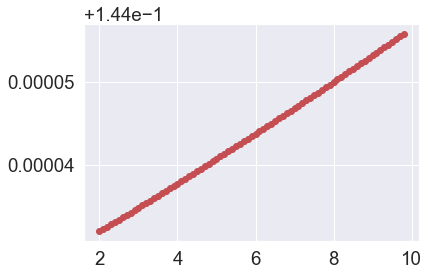

In [21]:
plt.plot(index[20:99], lasso_coef[20:99], 'ro')

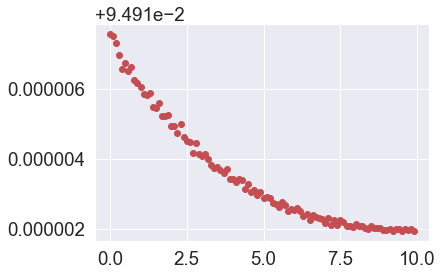

In [22]:
ridge_coef = []
index_100 =[]
for i in range (100):
    ridge = Ridge(alpha=i*0.1).fit(x_train,y_train)
    ridge.predict(x_test)
    ridge_coef.append(mean_squared_error(y_test, ridge.predict(x_test)))
    index_100.append(0.1*i)
plt.plot(index_100, ridge_coef, 'ro')

In [23]:
ridge_coef[0]

0.09491756562621659

# Region

In [24]:
data_column = data['region'].unique()

In [25]:
data_temp = data
for d in data_column:
    temp = (data['region']==d)
    data_temp[d] = temp

In [26]:
data_temp.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,...,Indianapolis,Columbus,Roanoke,Albany,Pittsburgh,BuffaloRochester,Louisville,Spokane,Boise,Syracuse
0,47,2017-02-05,0.66,11274749.11,4377537.67,2558039.85,193764.89,4145406.70,2508731.79,1627453.06,...,False,False,False,False,False,False,False,False,False,False
1,47,2017-02-05,0.67,11213596.29,3986429.59,3550403.07,214137.93,3462625.70,3403581.49,7838.83,...,False,False,False,False,False,False,False,False,False,False
2,7,2018-02-04,0.80,10894677.77,4473811.63,4097591.67,146357.78,2176916.69,2072477.62,34196.27,...,False,False,False,False,False,False,False,False,False,False
3,7,2018-02-04,0.83,10565056.41,3121272.58,3294335.87,142553.21,4006894.75,1151399.33,2838239.39,...,False,False,False,False,False,False,False,False,False,False
4,46,2016-02-07,0.70,10361698.17,2930343.28,3950852.38,424389.60,3056112.91,2693843.02,344774.59,...,False,False,False,False,False,False,False,False,False,False


In [27]:
reg

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [28]:
x = data_temp.drop(['AveragePrice','region','Date'], axis = 1)
y = data_temp.AveragePrice

x_train,x_test,y_train,y_test = train_test_split(x,y,random_state = 0)

In [29]:
reg = LinearRegression().fit(x_train, y_train)
mean_squared_error(y_test, reg.predict(x_test))

0.0715737717518344

In [30]:
lasso = linear_model.Lasso(alpha=0.1).fit(x_train, y_train)
lasso.predict(x_test)
mean_squared_error(y_test, lasso.predict(x_test))

0.14186520044862683

In [31]:
ridge = Ridge(alpha=100.0).fit(x_train,y_train)
ridge.predict(x_test)
mean_squared_error(y_test, ridge.predict(x_test))

0.07362448894084975

In [32]:
cpdf = pd.DataFrame()
cpdf['Value'] = y_test
cpdf['Ridge'] = ridge.predict(x_test)
cpdf['Lasso'] = lasso.predict(x_test)
cpdf['LR'] = reg.predict(x_test)
cpdf.head()

,Value,Ridge,Lasso,LR
8933,1.74,1.692857,1.489009,1.717617
1644,1.32,1.352852,1.363053,1.401573
2330,1.42,1.355263,1.343587,1.392672
2777,1.11,0.986813,1.373590,0.915103
4173,1.09,1.101300,1.406338,1.080579


This proves that region helps increase model performance.

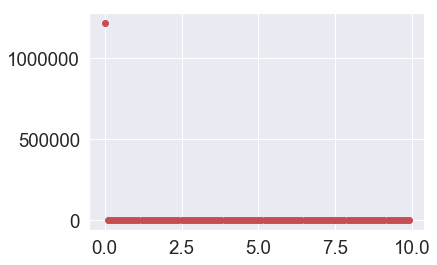

In [35]:
ridge_coef_region = []
for i in range (100):
    ridge = Ridge(alpha=i*0.1).fit(x_train,y_train)
    ridge_coef_region.append(mean_squared_error(y_test, ridge.predict(x_test)))

plt.plot(index, ridge_coef_region, 'ro')

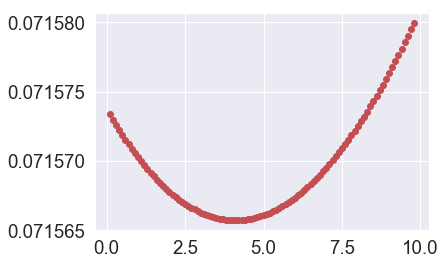

In [36]:
plt.plot(index[1:99], ridge_coef_region[1:99], 'ro')

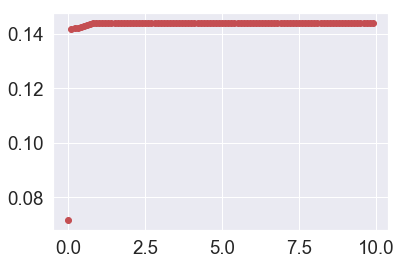

In [37]:
lasso_coef_region = []
for i in range (100):
    lasso = linear_model.Lasso(alpha=0.1*i).fit(x_train, y_train)
    lasso_coef_region.append( mean_squared_error(y_test, lasso.predict(x_test)))

plt.plot(index, lasso_coef_region, 'ro')


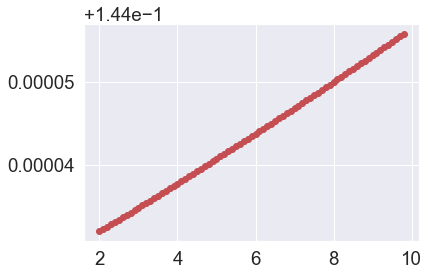

In [38]:
plt.plot(index[20:99], lasso_coef_region[20:99], 'ro')

In [ ]:
len(lasso_coef_region)

In [ ]:
x_test.head()

# Try Square root

In [39]:
y_test_sqrt = np.sqrt(y_test)
y_train_sqrt = np.sqrt(y_train)


In [41]:
reg_sqrt = LinearRegression().fit(x_train, y_train_sqrt)
mean_squared_error(y_test_sqrt, reg.predict(x_test))

0.10041397871910589

In [44]:
lasso_sqrt = linear_model.Lasso(alpha=0.2).fit(x_train, y_train_sqrt)
mean_squared_error(y_test_sqrt, lasso.predict(x_test))

0.08715617443181285

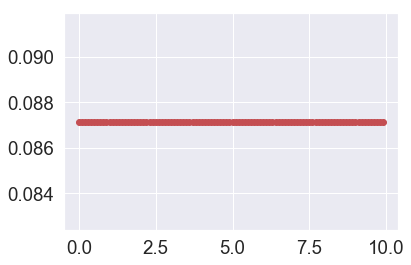

In [45]:
lasso_sqrt_coef_region = []
for i in range (100):
    lasso_sqrt = linear_model.Lasso(alpha=0.1*i).fit(x_train, y_train_sqrt)
    lasso_sqrt_coef_region.append( mean_squared_error(y_test_sqrt, lasso.predict(x_test)))

plt.plot(index, lasso_sqrt_coef_region, 'ro')


In [48]:
lasso_sqrt = linear_model.Lasso(alpha=0.1).fit(x_train, y_train_sqrt)
mean_squared_error(y_test_sqrt, lasso.predict(x_test))

0.08715617443181285

In [52]:
lasso_sqrt = linear_model.Lasso(alpha=0.1).fit(x_train, y_train_sqrt)
mean_squared_error(y_test_sqrt, lasso.predict(x_test))

0.08715617443181285

In [53]:
lasso.predict(x_test)

array([1.46195182, 1.40312372, 1.29413722, ..., 1.4337711 , 1.4622749 ,
       1.46842282])